# DPA (BiLSTM-BiLSTM, VGG-CNN)

In [1]:
import tensorflow as tf

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from keras.callbacks import EarlyStopping
from keras.layers import (Activation, Attention, Bidirectional, Concatenate, Conv1D,
                           Dense, Dropout, Embedding, Flatten, GlobalMaxPooling1D,
                           Input, Layer, LSTM, MaxPooling1D, Multiply, Permute,
                           RepeatVector, Reshape, SpatialDropout1D, TimeDistributed)
from keras.models import Model
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

import sys
sys.path.append('./cs16')
import cs16.prep as prep16
import cs16.plot as plot16
import cs16.build as build16
imagesize = 64

import pandas as pd

data_type = input("Enter '1. single' for single dataset or '2. multi' for multiple dataset: ")

if data_type == '1':
    file_path = 'single.txt'
    folder_path = './data/MVSA/single/'
elif data_type == '2':
    file_path = 'multi.txt'
    folder_path = './data/MVSA/multiple/'
else:
    print("Invalid input. Please enter either 'single' or 'multi'.")
    exit()

df = pd.read_csv(file_path, index_col=None, encoding='ISO-8859-1')

Enter '1. single' for single dataset or '2. multi' for multiple dataset: 2


In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
# Download stopwords and punkt tokenizer if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

#----------------------------------------------------
# NLP preprocess
#----------------------------------------------------
# Define a function to preprocess text
def nlp_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs 
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize text into individual words
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stem words using Porter Stemmer
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Join words back into a single string
    text = ' '.join(words)
    
    return text


# Apply the preprocess_text function to the 'tweet' column of the dataframe
df['tweet'] = df['tweet'].apply(nlp_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
X_text, y_text = prep16.preprocess_text(df)
X_train_text, X_val_text, X_test_text, \
y_train_text, y_val_text, y_test_text = prep16.split_data(X_text, y_text, random_state=42)

X_polar, y_polar = prep16.preprocess_text(df,label = 'polarity')
X_train_polar, X_val_polar, X_test_polar, \
y_train_polar, y_val_polar, y_test_polar = prep16.split_data(X_polar, y_polar, random_state=42)

image_data_s, image_label_s = prep16.preprocess_images(df, folder_path, imagesize)
y_s = to_categorical(image_label_s, num_classes=3)

X_train_image, X_val_image, X_test_image, \
y_train_image, y_val_image, y_test_image= prep16.split_data(image_data_s, y_s, random_state=42)

y_train = to_categorical(y_train_polar, num_classes=3)
y_val =to_categorical(y_val_polar, num_classes=3)
y_test =to_categorical(y_test_polar, num_classes=3)
file_path

'multi.txt'

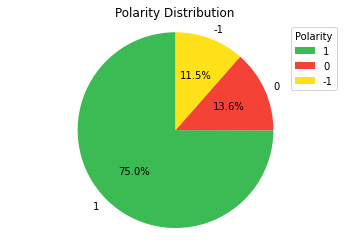

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
# distribution of polarity
polarity_counts =df['polarity'].value_counts(normalize=True)

# assign colors for each category
colors = ['#3cba54', '#f44336', '#ffe119']

# Create a pie chart of the polarity distribution
plt.pie(polarity_counts.values, labels=polarity_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Polarity Distribution')
plt.legend(title='Polarity', loc='best')
plt.show()

# BiLSTM

In [7]:
#---------------ContentAttention--------------------
# code adopted and modified from : 
# https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/
# https://www.kaggle.com/code/haithemhermessi/attention-mechanism-keras-as-simple-as-possible

class ContentAttention(Layer):
    def __init__(self, **kwargs):
        super(ContentAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(ContentAttention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)   
#import AveragePooling2D
from keras.layers import (AveragePooling1D)
from tensorflow.keras import regularizers

text_af = 'tanh'
text_input = Input(shape=(100,), name='text_input')
time_steps = 1000
features = 5
#----------LSTM1----------------
lstm1 = Embedding(input_dim=10000, output_dim=100)(text_input)
lstm1 = Dropout(0.25)(lstm1)  # Add a dropout layer
lstm1 = Bidirectional(LSTM(64, return_sequences=True, input_shape=(time_steps, features)))(lstm1)
#lstm1 = Dense(64, activation=text_af, kernel_regularizer=regularizers.l2(0.01))(lstm1)
lstm1 = ContentAttention()(lstm1)
lstm1 = Dropout(0.25)(lstm1)  # Add a dropout layer

#---------LSTM2-----------------
lstm2 = Embedding(input_dim=10000, output_dim=100)(text_input)
lstm2 = Dropout(0.5)(lstm2)  # Add a dropout layer
lstm2 = Bidirectional(LSTM(128, return_sequences=True, input_shape=(time_steps, features)))(lstm2)
#lstm2 = Dense(64, activation=text_af, kernel_regularizer=regularizers.l2(0.01))(lstm2)
lstm2 = ContentAttention()(lstm2)
lstm2 = Dropout(0.5)(lstm2)  # Add a dropout layer

#----------local fusion---------------
merged_layer = Concatenate()([lstm1, lstm2]) 
merged = Dense(3, activation='tanh')(merged_layer)
text_output = merged
textclassifier ='BiLSTM + BiLSTM'
print(textclassifier)

BiLSTM + BiLSTM


# CNN + VGG

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Concatenate, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

imageclassifier = 'CNN+ VGG'

# ------------ pipeline1:CNN --------------------------
image_input = Input(shape=(imagesize, imagesize, 3), name='image_input')
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = Dropout(0.25)(pool1)
pool1 = BatchNormalization()(pool1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = Dropout(0.25)(pool2)
pool2 = BatchNormalization()(pool2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
pool3 = Dropout(0.25)(pool3)
pool3 = BatchNormalization()(pool3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
pool4 = Dropout(0.25)(pool4)
pool4 = BatchNormalization()(pool4)

# Add spatial attention to CNN features
cnn1_attention = Conv2D(1, (1, 1), activation='sigmoid')(pool4)
attended_features = Multiply()([pool4, cnn1_attention])

cnn1_flatten = Flatten()(attended_features)
#--------------pipeline2:VGG--------------------------------
# Load pre-trained VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(imagesize, imagesize, 3))

# Freeze the weights of the VGG16 layers
for layer in vgg16_base.layers:
    layer.trainable = False

vgg16_features = vgg16_base(image_input)

# Add spatial attention to VGG16 features
attention = Conv2D(1, (1, 1), activation='sigmoid')(vgg16_features)
attended_features = Multiply()([vgg16_features, attention])

# Flatten the attended features
vgg_flatten = Flatten()(attended_features)

#----------local fusion---------------
merged_features = Concatenate()([cnn1_flatten, vgg_flatten])

# Apply the rest of the model layers
merged = Dense(256, activation='relu')(merged_features)
merged = Dropout(0.3)(merged)
image_output = Dense(3, activation='relu', kernel_regularizer=regularizers.l2(0.05))(merged)

print(imageclassifier)

CNN+ VGG


# Early FUSION

In [9]:
from keras.optimizers import Adam, Adagrad, RMSprop
from keras import backend as K
from keras import metrics

concatenated = Concatenate()([text_output, image_output])
# Final output layers
output = Dense(3, activation='softmax')(concatenated)
model = Model(inputs=[text_input, image_input], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit([X_train_text, X_train_image], y_train, 
                    validation_data=([X_val_text, X_val_image], y_val),
                    epochs=7, 
                    batch_size=64)

# Evaluate the model
test_loss, test_acc = model.evaluate([X_test_text, X_test_image], y_test)
print('Test accuracy:', test_acc)


Epoch 1/7
244/244 [==============================] - 529s 2s/step - loss: 0.8456 - accuracy: 0.7434 - val_loss: 0.7087 - val_accuracy: 0.7704
Epoch 2/7
244/244 [==============================] - 527s 2s/step - loss: 0.7276 - accuracy: 0.7474 - val_loss: 0.6551 - val_accuracy: 0.7750
Epoch 3/7
244/244 [==============================] - 519s 2s/step - loss: 0.6500 - accuracy: 0.7610 - val_loss: 0.6462 - val_accuracy: 0.7756
Epoch 4/7
244/244 [==============================] - 525s 2s/step - loss: 0.5940 - accuracy: 0.7781 - val_loss: 0.6515 - val_accuracy: 0.7684
Epoch 5/7
244/244 [==============================] - 475s 2s/step - loss: 0.5381 - accuracy: 0.7985 - val_loss: 0.6904 - val_accuracy: 0.7396
Epoch 6/7
244/244 [==============================] - 524s 2s/step - loss: 0.4943 - accuracy: 0.8200 - val_loss: 0.7228 - val_accuracy: 0.7422
Epoch 7/7
61/61 [==============================] - 42s 685ms/step - loss: 0.7619 - accuracy: 0.7318
Test accuracy: 0.7317574620246887


In [10]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on test data
y_pred = model.predict([X_test_text, X_test_image])

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print(f"***** Text:{textclassifier} Image:{imageclassifier} ***** ")
# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, digits = 4)

# Print the report
print('Classification Report:\n', report)


61/61 [==============================] - 45s 702ms/step
***** Text:BiLSTM + BiLSTM Image:CNN+ VGG ***** 
Classification Report:
               precision    recall  f1-score   support

           0     0.2263    0.1220    0.1586       254
           1     0.7981    0.9144    0.8523      1461
           2     0.4222    0.2468    0.3115       231

    accuracy                         0.7318      1946
   macro avg     0.4822    0.4277    0.4408      1946
weighted avg     0.6788    0.7318    0.6976      1946



# LATE FUSION

In [11]:
#----------------image
image_feature_extractor = Model(inputs=image_input, outputs=image_output)

val_image_features = image_feature_extractor.predict(X_val_image)
test_image_features = image_feature_extractor.predict(X_test_image)

#--------------text
text_feature_extractor = Model(inputs=text_input, outputs=text_output)

val_text_features = text_feature_extractor.predict(X_val_text)
test_text_features = text_feature_extractor.predict(X_test_text)

#---------------combine
val_features = np.concatenate([val_image_features, val_text_features], axis=1)
test_features = np.concatenate([test_image_features, test_text_features], axis=1)

# Convert validation labels to one-hot encoded vectors
y_val_labels = y_val_polar #np.argmax(y_val_image, axis=1)
y_test_labels = y_test_polar#np.argmax(y_test_image, axis=1)

print(f"Text:{textclassifier} Image:{imageclassifier} ")

61/61 [==============================] - 5s 77ms/step
Text:BiLSTM + BiLSTM Image:CNN+ VGG 


## XGB

In [46]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_val_labels_encoded = label_encoder.fit_transform(y_val_labels)
y_test_labels_encoded = label_encoder.transform(y_test_labels)

xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5) #reg_lambda reg_alpha

# Train the XGBoost model
xgb_model.fit(val_features, y_val_labels_encoded)

# Evaluate the model
xgb_score = xgb_model.score(test_features, y_test_labels_encoded)
print("Late Fusion Test Accuracy: {:.2f}%".format(xgb_score * 100))

y_pred = xgb_model.predict(test_features)
print(f"Text:{textclassifier} Image:{imageclassifier} ")
# Print classification report
print(classification_report(y_test_labels_encoded, y_pred, digits=4))

Late Fusion Test Accuracy: 72.97%
Text:BiLSTM + BiLSTM Image:CNN+ VGG 
              precision    recall  f1-score   support

           0     0.2871    0.1255    0.1747       231
           1     0.0909    0.0157    0.0268       254
           2     0.7701    0.9493    0.8504      1461

    accuracy                         0.7297      1946
   macro avg     0.3827    0.3635    0.3506      1946
weighted avg     0.6241    0.7297    0.6627      1946



## Random Forest

In [27]:
#--------------logistic Regression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=4)

rf.fit(val_features, y_val_labels)
rf_score = rf.score(test_features, y_test_labels)
print("Late Fusion Test Accuracy: {:.2f}%".format(rf_score * 100))
#from sklearn.metrics import classification_report

# Predict labels for test data
y_pred = rf.predict(test_features)
print(f"Text:{textclassifier} Image:{imageclassifier} ")
# Print classification report
print(classification_report(y_test_labels, y_pred, digits=4))

Late Fusion Test Accuracy: 75.75%
Text:BiLSTM + BiLSTM Image:CNN+ VGG 
              precision    recall  f1-score   support

          -1     0.4400    0.1905    0.2659       231
           0     0.0000    0.0000    0.0000       254
           1     0.7746    0.9788    0.8648      1461

    accuracy                         0.7575      1946
   macro avg     0.4049    0.3898    0.3769      1946
weighted avg     0.6338    0.7575    0.6808      1946



C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression

In [30]:
#--------------logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(val_features, y_val_labels)
lr_score = lr.score(test_features, y_test_labels)
print("Late Fusion Test Accuracy: {:.2f}%".format(lr_score * 100))
#from sklearn.metrics import classification_report

# Predict labels for test data
y_pred = lr.predict(test_features)
print(f"Text:{textclassifier} Image:{imageclassifier} ")
# Print classification report
print(classification_report(y_test_labels, y_pred, digits=4))

Late Fusion Test Accuracy: 75.64%
Text:BiLSTM + BiLSTM Image:CNN+ VGG 
              precision    recall  f1-score   support

          -1     0.4322    0.2208    0.2923       231
           0     0.0000    0.0000    0.0000       254
           1     0.7774    0.9726    0.8641      1461

    accuracy                         0.7564      1946
   macro avg     0.4032    0.3978    0.3855      1946
weighted avg     0.6349    0.7564    0.6834      1946



C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ausco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# MLP

In [49]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Create an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 32), 
                    activation='relu', solver='lbfgs', learning_rate = 'invscaling')

# Fit the classifier to the training data
mlp.fit(val_features, y_val_labels)

# Evaluate the classifier on the test data
mlp_score = mlp.score(test_features, y_test_labels)
print("Late Fusion Test Accuracy: {:.2f}%".format(mlp_score * 100))

# Predict labels for the test data
y_pred = mlp.predict(test_features)

# Print classification report
print(classification_report(y_test_labels, y_pred, digits=4))

Late Fusion Test Accuracy: 75.75%
              precision    recall  f1-score   support

          -1     0.4396    0.1732    0.2484       231
           0     0.4286    0.0118    0.0230       254
           1     0.7744    0.9795    0.8649      1461

    accuracy                         0.7575      1946
   macro avg     0.5475    0.3881    0.3788      1946
weighted avg     0.6895    0.7575    0.6818      1946



C:\Users\ausco\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


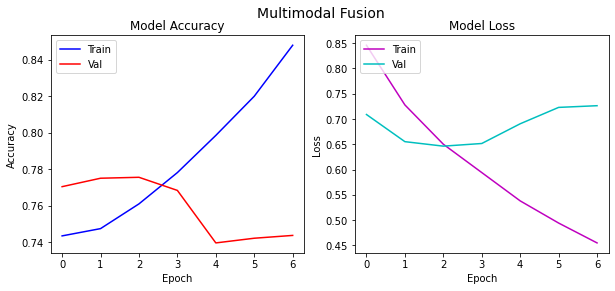

In [28]:
plot16.plot_hist(history, 'Multimodal Fusion')

# AUC-ROC

61/61 [==============================] - 30s 499ms/step


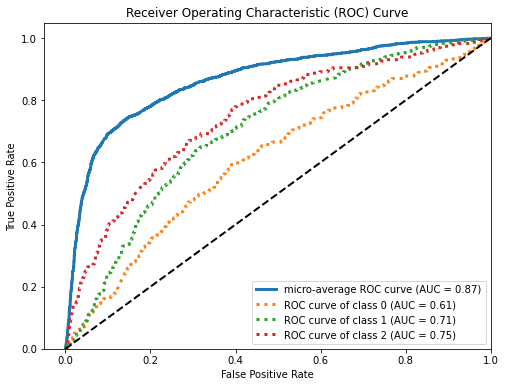

In [29]:
X_test = [X_test_text, X_test_image]
plot16.plot_roc(model, X_test, y_test)